This notebook will be used to look at and understand the model output currents through Haro Strait with the use of ellipses

In [1]:
import os
import glob
import datetime
import matplotlib.pylab as plt
import matplotlib.ticker as ticker
from matplotlib.patches import Ellipse
import numpy as np
from IPython.display import display, Math, Latex
import csv
import pandas as pd
import re
import subprocess as sp
from subprocess import Popen, PIPE

import netCDF4 as nc
from scipy.optimize import curve_fit
import scipy.io as sio
from salishsea_tools import (viz_tools,tidetools, nc_tools)
from salishsea_tools.nowcast import (research_VENUS, analyze)

%matplotlib inline

#Which grid points do we want to focus on?

In [2]:
thalweg = np.loadtxt('/data/dlatorne/MEOPAR/tools/bathymetry/thalweg_working.txt', dtype=int, unpack=True)
grid = '/data/nsoontie/MEOPAR/NEMO-forcing/grid/bathy_meter_SalishSea2.nc'
fB = nc.Dataset(grid)
bathy = fB.variables['Bathymetry'][:]
X = fB.variables['nav_lon'][:]
Y = fB.variables['nav_lat'][:]

In [3]:
#Haro Strait
iH = 233
jH = 312

[210, 250, 280, 360]

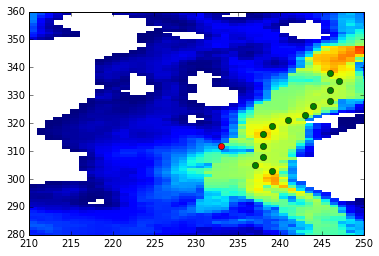

In [4]:
plt.pcolormesh(bathy)
plt.plot(iH,jH,'ro')
plt.plot(thalweg[1,480:530:4],thalweg[0,480:530:4], 'go')
plt.axis([210,250,280,360])

##Loading parameters
The parameters have been calculated in [SaveTidalParameters](http://nbviewer.ipython.org/urls/bitbucket.org/salishsea/analysis/raw/tip/Muriel/SaveTidalParameters.ipynb) because they take a long time to load and are consitent for a chosen time period.

In [5]:
to = datetime.datetime(2014,11,26)
tf = datetime.datetime(2015, 6, 29)

t_o = to.strftime('%d%b%y').lower()
t_f = tf.strftime('%d%b%y').lower()

loc = np.arange(480,530,4)
count = np.arange(0,len(loc))
parh = np.zeros((len(loc),39,5))
parh_av = np.zeros((len(loc),8))
cols=np.arange(0,5)

i = np.zeros((16))
j = np.zeros((16))


for k,l in zip(loc,count):
    i = thalweg[1,loc]
    j = thalweg[0,loc]
    runname1 = '{}_{}_HaroS_{}'.format(t_o, t_f, k)
    runname2 = '{}_{}_HaroS_{}_depav(0-400)'.format(t_o, t_f, k)
    df1 = pd.read_csv('TidalEllipseData/HaroStrait/'+runname1+'.csv', usecols=cols) 
    df2 = pd.read_csv('TidalEllipseData/HaroStrait/'+runname2+'.csv', index_col=False)
    parh[l,:,:] = df1.as_matrix()
    parh_av[l,:] = df2.as_matrix()


In [6]:
parh[0,:,0][::2]

array([   0.5    ,    2.50001,    4.50007,    6.50031,    8.50124,
         10.5048 ,   12.5182 ,   14.569  ,   16.7612 ,   19.4818 ,
         24.1003 ,   34.6858 ,   58.4843 ,   98.063  ,  147.089  ,
        199.573  ,  253.067  ,  306.834  ,  360.675  ,  414.534  ])

##Model Ellipses with Depth

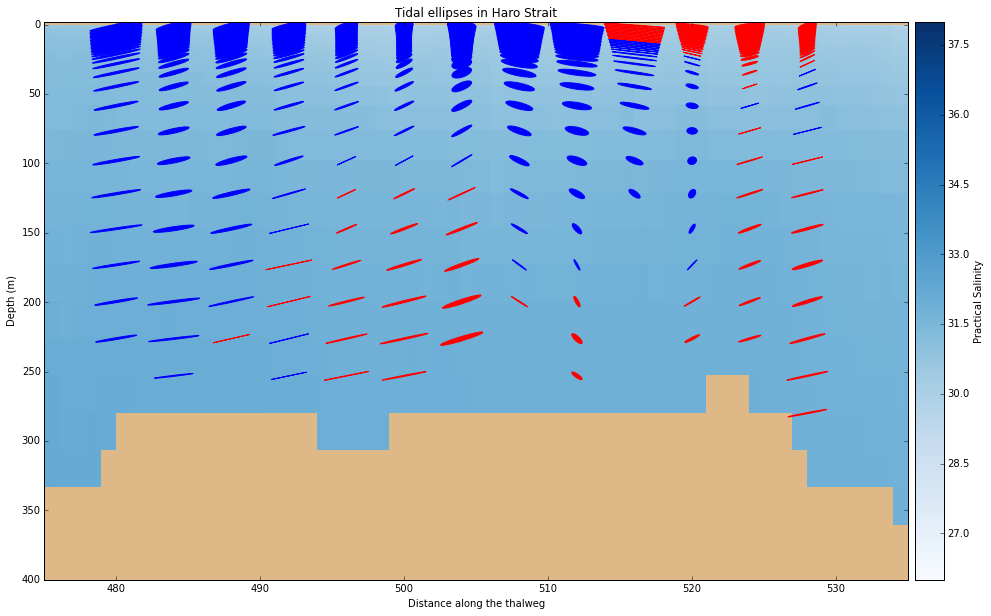

In [7]:
# Set up the figure and axes
fig, (axl, axcb) = plt.subplots(1, 2, figsize=(20, 10))
land_colour = 'burlywood'
axl.set_axis_bgcolor(land_colour)
axl.set_position((0.125, 0.125, 0.6, 0.775))
axcb.set_position((0.73, 0.125, 0.02, 0.775))

smin, smax, dels = 26, 38, 0.5
cmap = plt.get_cmap('Blues')
cmap.set_bad(land_colour)
tracers = nc.Dataset('/ocean/dlatorne/MEOPAR/SalishSea/results/spin-up/18sep27sep/SalishSea_1d_20030918_20030927_grid_T.nc')
sal = tracers.variables['vosaline']
npsal = sal[:]
zlevels = tracers.variables['deptht']
sal_0 = npsal[-1, :, thalweg[0], thalweg[1]]
sal_tzyx = np.ma.masked_values(sal_0, 0)
x, z = np.meshgrid(np.arange(thalweg.shape[1]), zlevels)
mesh = axl.pcolormesh(x, z, sal_tzyx.T, cmap=cmap, vmin=smin, vmax=smax)
cbar = plt.colorbar(mesh, cax=axcb)
cbar.set_label('Practical Salinity')

scale = 10


for c, ind in zip(count, loc):
    for dep, value in zip(np.arange(0,39), parh[0,:,0]):
        if parh[c,dep,2] > 0:
            thec = 'b'
        else:
            thec = 'r'
        ellsc = Ellipse(xy=(ind, value), width=scale*parh[c,dep,1], 
                            height=scale*parh[c,dep,2], angle=parh[c, dep,3],
                            color=thec)
        axl.add_artist(ellsc)
        ellsc.set_facecolor(thec)


axl.set_ylim(-2,400)
axl.invert_yaxis()
axl.set_xlim(475,535)
axl.set_title('Tidal ellipses in Haro Strait')
axl.set_ylabel('Depth (m)')
axl.set_xlabel('Distance along the thalweg')


They are mostly going northwards... larger values at the surface

##Load Foreman values

In [8]:
i = thalweg[1,loc]
j = thalweg[0,loc]

lon = X[j,i]
lat = Y[j,i]
print lat[:], lon[count]

[ 48.51210785  48.51619339  48.52997589  48.54579926  48.5616188
  48.57539368  48.58712006  48.59884644  48.61261749  48.62434006
  48.64014435  48.65390778  48.66384888] [-123.16444397 -123.18154144 -123.18635559 -123.19971466 -123.21307373
 -123.21788788 -123.2141571  -123.21042633 -123.21524048 -123.21151733
 -123.22489166 -123.22971344 -123.24494934]


In [90]:
ans = np.zeros((13,4))
os.chdir(r'/ocean/mdunn/Tides/')
for i in count:
    p = Popen(["matlab","-nodesktop","-nodisplay","-r", "findparam(%s,%s)" % (lon[i], lat[i])], stdout=PIPE, stderr=PIPE)
    output, err = p.communicate()
    ans[i] = output[426:462].split()


The nodes are too close together for the Foreman model. The output is the same everywhere...

3.3513


TypeError: 'list' object is not callable